In [ ]:
# Some general purpose stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Used sklearn methods
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# For austrian holidays calendar
import holidays

# Ignore annoying deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [24]:
#####################
# Prepare some data #
#####################

,TOTAL,MV,STD,RSD
Argentinierstrasse,1768924,1613.981752,856.719160,0.530811
Donaukanal,1399333,1276.763686,970.248693,0.759928
Langobardenstrasse,449307,409.951642,249.853803,0.609471
Lassallestrasse,2499977,2281.000912,1710.599786,0.749934
Liesingbach,451647,412.086679,304.071217,0.737882
Neubaugürtel,1570606,1433.034672,746.012893,0.520583
Opernring Innen,3008949,2745.391423,1554.051878,0.566058
Opernring Aussen,1592886,1453.363139,796.067324,0.547742
Wienzeile,1016578,927.534672,593.755266,0.640143
Margaritensteg,1010687,922.159672,543.085224,0.588928


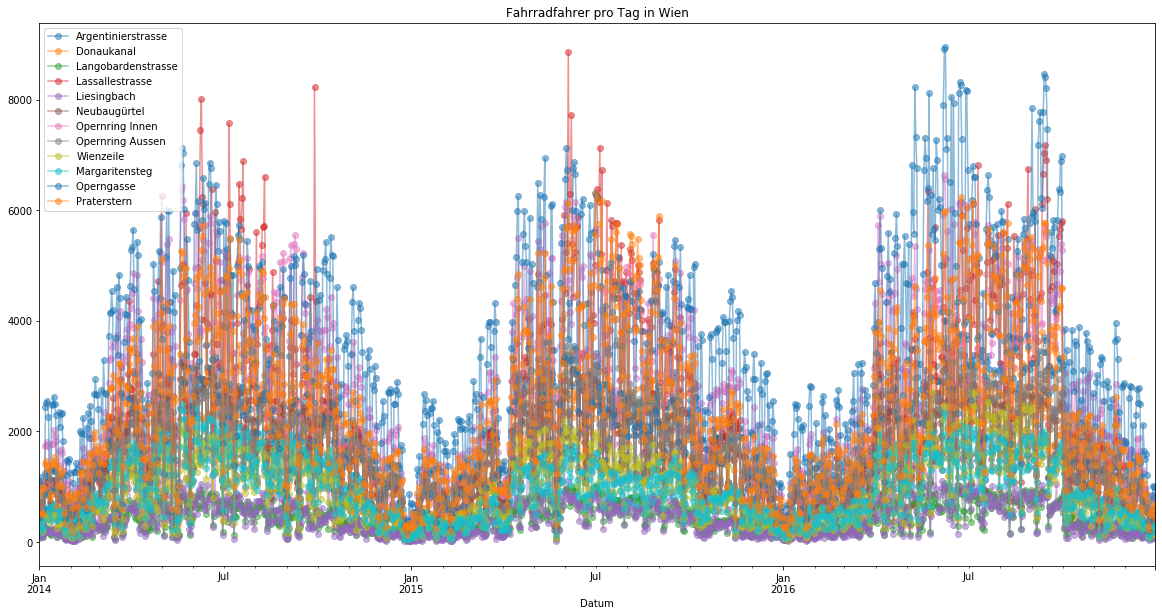

In [58]:
# Import bicycle traffic data
targets = pd.read_csv("data/rad_vz_2014-2016.csv", sep=',',
                          index_col="Datum", parse_dates=True)
# Get some statistics
trafficStats = pd.DataFrame()
trafficStats['TOTAL'] = targets.sum(axis=0) 
trafficStats['MV'] = targets.mean()
trafficStats['STD'] = targets.std()
trafficStats['RSD'] = trafficStats['STD']/trafficStats['MV']

# Selcet 'Neubaugürtel' as target
target = targets['Neubaugürtel']

# Plot all the traffic data
targets.plot(marker='o', figsize=(20,10), alpha=0.5, title='Fahrradfahrer pro Tag in Wien');
trafficStats

In [26]:
# Import weather data (only some of it)
weatherCols = ['Datum', 
               'Mittelwert der Lufttemperatur (C)',
               'Niederschlag (mm)',
               'Neuschnee (cm)',
               'Globalstrahlung (J/cm^2)']
features = pd.read_csv('data/ZAMG_Jahrbuch_2014-2016.csv', sep=';', header=9, 
                       usecols=weatherCols, index_col='Datum', 
                       parse_dates=True, dayfirst=True)

# Boolean indicator for rain and snow
isRainThreshold = 1. # mm
features['Niederschlag'] = (features['Niederschlag (mm)'] >= isRainThreshold).astype(int)
features['Neuschnee'] = (features['Neuschnee (cm)'] > 0.).astype(int)
features = features.drop(columns=['Neuschnee (cm)'])

# Calculate hours of daylight
def hours_of_daylight(date, axis=23.44, latitude=48.12):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
#features['Sonnenstunden (h)'] = list(map(hours_of_daylight, weatherData.index))

# Boolean indicator for weekday
days = ['Mo', 'Di', 'Mi', 'Do', 'Fr', 'Sa', 'So']
for i in range(7):
    features[days[i]] = (features.index.dayofweek == i).astype(int)

# Boolean indicator for austrian holiday
for date, idx in zip(features.index.date, features.index):
    features.at[idx,'Ferien'] = int(date in holidays.Austria())
features['Ferien'] = features['Ferien'].astype(int)

# Counter to identify an overall trend
features['Jahr'] = (features.index - features.index[0]).days / 365.

features.head()

,Mittelwert der Lufttemperatur (C),Niederschlag (mm),Globalstrahlung (J/cm^2),Niederschlag,Neuschnee,Mo,Di,Mi,Do,Fr,Sa,So,Ferien,Jahr
Datum,,,,,,,,,,,,,,
2014-01-01,5.0,0.0,318,0,0,0,0,1,0,0,0,0,1,0.000000
2014-01-02,4.8,0.8,326,0,0,0,0,0,1,0,0,0,0,0.002740
2014-01-03,2.3,0.0,492,0,0,0,0,0,0,1,0,0,0,0.005479
2014-01-04,3.1,0.0,104,0,0,0,0,0,0,0,1,0,0,0.008219
2014-01-05,8.1,0.6,239,0,0,0,0,0,0,0,0,1,0,0.010959


In [27]:
###############################
# Build and train some models #
###############################

# Number of splitting for cross validation
cvNumber = 5

# Dataframe for predictions and real values
predicted = pd.DataFrame(index=target.index)
predicted['Real'] = target

# Dataframe to record scoring of different regression methods
scores = pd.DataFrame(columns=['R2', 'R2 (std)'])

In [28]:
# LINEAR MODEL

# Build model
linearModel = LinearRegression()

# Cross validation of model
scoresLin = cross_val_score(linearModel, features, target, cv=cvNumber)
scores.loc['LinearRegression'] = [scoresLin.mean(), scoresLin.std()]

# Add prediction to dataframe
linearModel.fit(features, target)
predicted['LinearRegression'] = linearModel.predict(features)

#############################
# Show model coefficients
#print('Lineare Regression: Modellparamter')
#print(pd.Series(linearModel.coef_, index=features.columns))

In [29]:
# RIDGE REGRESSION (L2 penalized)

# Build model
ridgeModel = Ridge()

# Grid search with cross validation for alpha
param_grid = [ {'alpha': np.logspace(-6, 6, 13)} ]
ridgeModel = GridSearchCV(ridgeModel, param_grid, cv=cvNumber)
scoresRidge = ridgeModel.fit(features, target)
scores.loc['Ridge'] = [scoresRidge.best_score_, scoresRidge.cv_results_['std_test_score'][scoresRidge.best_index_]]

# Add prediction to dataframe
predicted['Ridge'] = ridgeModel.predict(features)

############################
# Print optimal alpha
#print('alpha: ' + str(ridgeModel.alpha_) )
# Show model coefficients
#print('Ridge Regression: Modellparamter')
#print(pd.Series(ridgeModel.coef_, index=features.columns))

In [79]:
# MULTI LAYER PERCEPTRON

# Build multi layer perceptron for regression
mlpModel = MLPRegressor(solver='lbfgs')

# Grid search with cross validation for mlp hidden layers sizes
hiddenLayerSize = [ (depth, width) for depth in range(8,12) for width in range(8,12) ]
param_grid = [ {'hidden_layer_sizes': hiddenLayerSize} ]
mlpModel = GridSearchCV(mlpModel, param_grid, cv=cvNumber)
scoresMlp = mlpModel.fit(features, target)
scores.loc['MLPRegressor'] = [scoresMlp.best_score_, scoresMlp.cv_results_['std_test_score'][scoresMlp.best_index_]]

# Add prediction to dataframe
predicted['MLPRegressor'] = mlpModel.predict(features)

#############################
# Print optimal hidden layer size
#print("Optimal hidden layer size: (%u, %u )" 
#      % (scoresMlp.best_params_['hidden_layer_sizes'][0], scoresMlp.best_params_['hidden_layer_sizes'][1]))

,R2,R2 (std)
LinearRegression,0.777648,0.073234
Ridge,0.778045,0.073364
MLPRegressor,0.595032,0.103378


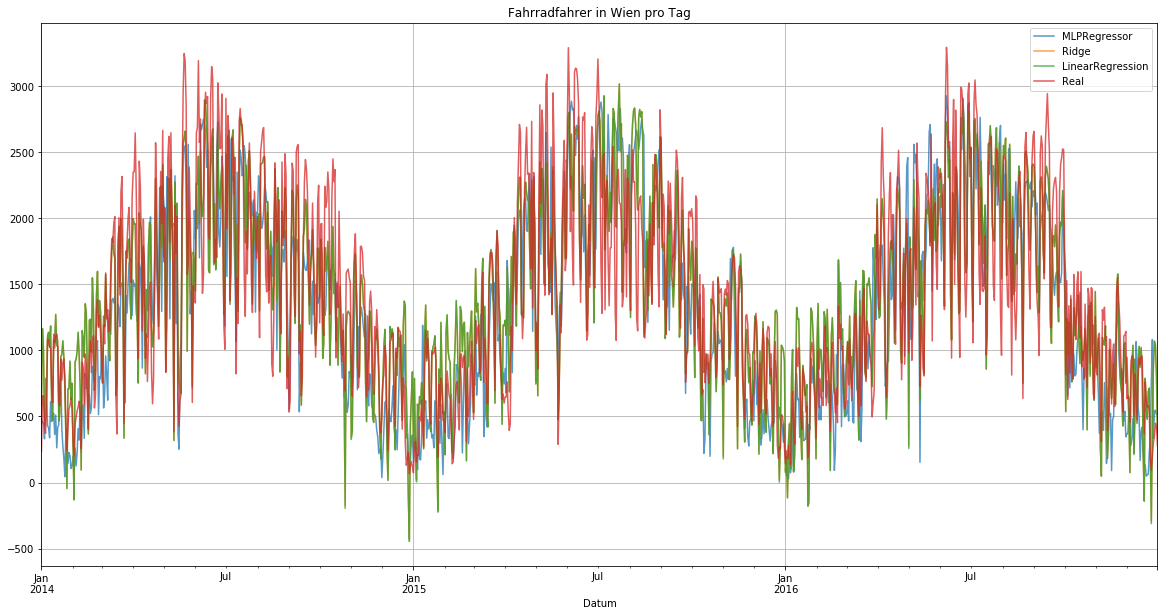

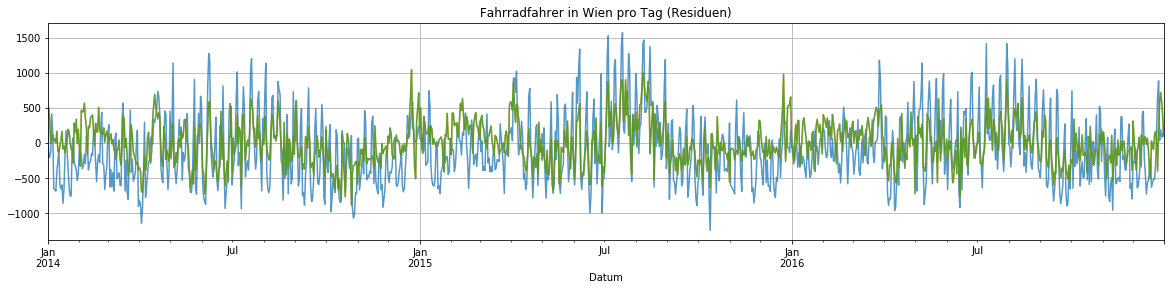

In [103]:
# Plot predictions and residuals
predicted.iloc[:, ::-1].plot(
    figsize=(20,10),
    grid=True, 
    alpha=0.75, 
    title='Fahrradfahrer in Wien pro Tag')
predicted.iloc[:, 1:].sub(predicted.iloc[:, 0], axis='index').iloc[:, ::-1].plot(
    figsize=(20,4), 
    grid=True, 
    alpha=0.75, 
    legend=False, 
    title='Fahrradfahrer in Wien pro Tag (Residuen)')

# And show the model scores from cross evaluation
scores